In [1]:
pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install traci

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
#SECTION 1 : IMPORTING ALL REQUIRED LIBRARIES

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import pickle
import subprocess

# PyTorch for Deep Q-Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Gymnasium (OpenAI Gym)
import gymnasium as gym
from gymnasium import spaces

# SUMO TraCI
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

import traci

print("All imports successful!")

All imports successful!


In [5]:
# SECTION 2: SUMO NETWORK CONFIGURATION FILES
# Creates a simple 4-way intersection network for traffic simulation

import subprocess 
def create_sumo_config_files():
    '''
    Creates SUMO network configuration files:
    - intersection.nod.xml: Node/junction definition
    - intersection.edg.xml: Edge/road definition
    - intersection.con.xml: Connection definition
    - intersection.rou.xml: Route and vehicle definition
    - intersection.sumocfg: Main configuration file
    '''

    # 1. NODE FILE (intersection.nod.xml)
    # Defines the junction/intersection
    node_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<nodes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/nodes_file.xsd">
    <node id="center" type="traffic_light" x="0.0" y="0.0"/>
    <node id="north" type="priority" x="0.0" y="100.0"/>
    <node id="south" type="priority" x="0.0" y="-100.0"/>
    <node id="east" type="priority" x="100.0" y="0.0"/>
    <node id="west" type="priority" x="-100.0" y="0.0"/>
</nodes>'''

    # 2. EDGE FILE (intersection.edg.xml)
    # Defines roads connecting to intersection
    edge_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<edges xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/edges_file.xsd">
    <edge id="N2C" from="north" to="center" numLanes="1" speed="13.89"/>
    <edge id="S2C" from="south" to="center" numLanes="1" speed="13.89"/>
    <edge id="E2C" from="east" to="center" numLanes="1" speed="13.89"/>
    <edge id="W2C" from="west" to="center" numLanes="1" speed="13.89"/>

    <edge id="C2N" from="center" to="north" numLanes="1" speed="13.89"/>
    <edge id="C2S" from="center" to="south" numLanes="1" speed="13.89"/>
    <edge id="C2E" from="center" to="east" numLanes="1" speed="13.89"/>
    <edge id="C2W" from="center" to="west" numLanes="1" speed="13.89"/>
</edges>'''

    # 3. CONNECTION FILE (intersection.con.xml)
    # Defines allowed movements through intersection
    connection_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<connections xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/connections_file.xsd">
    <connection from="N2C" to="C2S" fromLane="0" toLane="0"/>
    <connection from="N2C" to="C2E" fromLane="0" toLane="0"/>
    <connection from="N2C" to="C2W" fromLane="0" toLane="0"/>

    <connection from="S2C" to="C2N" fromLane="0" toLane="0"/>
    <connection from="S2C" to="C2E" fromLane="0" toLane="0"/>
    <connection from="S2C" to="C2W" fromLane="0" toLane="0"/>

    <connection from="E2C" to="C2W" fromLane="0" toLane="0"/>
    <connection from="E2C" to="C2N" fromLane="0" toLane="0"/>
    <connection from="E2C" to="C2S" fromLane="0" toLane="0"/>

    <connection from="W2C" to="C2E" fromLane="0" toLane="0"/>
    <connection from="W2C" to="C2N" fromLane="0" toLane="0"/>
    <connection from="W2C" to="C2S" fromLane="0" toLane="0"/>
</connections>'''


    # Write files
    with open('intersection.nod.xml', 'w') as f:
        f.write(node_xml)
    with open('intersection.edg.xml', 'w') as f:
        f.write(edge_xml)
    with open('intersection.con.xml', 'w') as f:
        f.write(connection_xml)

    # Generate network using NETCONVERT
    netconvert_cmd = [
        'netconvert',
        '--node-files=intersection.nod.xml',
        '--edge-files=intersection.edg.xml',
        '--connection-files=intersection.con.xml',
        '--output-file=intersection.net.xml'
    ]
    
    result = subprocess.run(netconvert_cmd, capture_output=True, text=True)

    if result.returncode != 0:
        print("==================================================")
        print("ERROR: netconvert failed!")
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        print("==================================================")
        raise RuntimeError("Failed to create SUMO network file. See error above.")
    else:
         print("SUMO network files created successfully!")


In [6]:
# SECTION 3: TRAFFIC GENERATION 

def generate_route_file(n_vehicles=1000, emergency_prob=0.1, depart_period=2.5):
    '''
    Generates vehicle routes with emergency vehicle probability
    Args:
        n_vehicles: Total number of vehicles to generate
        emergency_prob: Probability of vehicle being emergency vehicle
        depart_period: Time (in seconds) between vehicle departures
    '''

    routes = [
        ("N2C", "C2S"), ("N2C", "C2E"), ("N2C", "C2W"),
        ("S2C", "C2N"), ("S2C", "C2E"), ("S2C", "C2W"),
        ("E2C", "C2W"), ("E2C", "C2N"), ("E2C", "C2S"),
        ("W2C", "C2E"), ("W2C", "C2N"), ("W2C", "C2S")
    ]

    with open("intersection.rou.xml", "w") as route_file:
        route_file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        route_file.write('<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n')

        # Vehicle types
        route_file.write('    <vType id="normal" accel="2.6" decel="4.5" sigma="0.5" length="5" maxSpeed="13.89" color="1,1,0"/>\n')
        route_file.write('    <vType id="emergency" accel="3.5" decel="5.0" sigma="0.3" length="6" maxSpeed="20.0" color="1,0,0" guiShape="emergency"/>\n')

        # Generate routes
        for i, (origin, destination) in enumerate(routes):
            route_file.write(f'    <route id="route{i}" edges="{origin} {destination}"/>\n')

        # Generate vehicles
        for i in range(n_vehicles):
            route_id = random.randint(0, len(routes) - 1)
            depart_time = i * depart_period

            # Determine if emergency vehicle
            is_emergency = random.random() < emergency_prob
            v_type = "emergency" if is_emergency else "normal"

            route_file.write(f'    <vehicle id="veh{i}" type="{v_type}" route="route{route_id}" depart="{depart_time}"/>\n')

        route_file.write('</routes>\n')

    print(f"Generated route file with {n_vehicles} vehicles (1 vehicle every {depart_period}s)")

In [7]:
# SECTION 4: SUMO CONFIGURATION FILE

def create_sumo_config():
    '''Creates main SUMO configuration file'''

    config_xml = '''<?xml version="1.0" encoding="UTF-8"?>
<configuration xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/sumoConfiguration.xsd">
    <input>
        <net-file value="intersection.net.xml"/>
        <route-files value="intersection.rou.xml"/>
    </input>
    <time>
        <begin value="0"/>
        <end value="3600"/>
    </time>
    <processing>
        <time-to-teleport value="-1"/>
    </processing>
</configuration>'''

    with open('intersection.sumocfg', 'w') as f:
        f.write(config_xml)

    print("SUMO configuration file created!")

In [8]:
# SECTION 5: CUSTOM GYM ENVIRONMENT 

class TrafficLightEnv(gym.Env):
    '''
    Custom Gymnasium Environment for Adaptive Traffic Light Control
    (Modifications for Tabular Q-Learning & Video Recording)
    '''

    def __init__(self, gui=False, max_steps=1000, record_data=False): # <-- Added record_data
        super(TrafficLightEnv, self).__init__()

        # Environment parameters
        self.gui = gui
        self.max_steps = max_steps
        self.current_step = 0
        self.record_data = record_data
        self.viz_data = []
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([100, 100, 1, 1, 1], dtype=np.float32), # Increased cap
            dtype=np.float32
        )
        
        # Action space: 0 = Keep Phase, 1 = Switch Phase
        self.action_space = spaces.Discrete(2)

        # Traffic light parameters
        self.current_phase = 0  # 0 = NS green, 1 = EW green
        self.yellow_time = 4  # Yellow light duration
        self.min_green_time = 10  # Minimum green time
        self.time_since_phase_change = 0
        self.total_waiting_time = 0
        self.total_vehicles_passed = 0
        self.phase_switches = 0
        self.emergency_vehicles_cleared = 0
        self.sumo_cmd = None
        self.sumo_running = False
        self.w1_throughput = 1.0
        self.w2_queue = 0.3
        self.w3_switch = 0.05
        self.w4_emergency = 3.0
        self.ns_lanes = ['N2C_0', 'S2C_0']
        self.ew_lanes = ['E2C_0', 'W2C_0']


    def _start_sumo(self):
        if self.sumo_running:
            traci.close()
        sumo_binary = 'sumo-gui' if self.gui else 'sumo'
        self.sumo_cmd = [
            sumo_binary,
            '-c', 'intersection.sumocfg',
            '--no-step-log', 'true',
            '--waiting-time-memory', '1000',
            '--no-warnings', 'true',
            '--duration-log.disable', 'true'
        ]
        try:
            traci.start(self.sumo_cmd)
            self.sumo_running = True
        except traci.TraCIException as e:
            print(f"Error starting TraCI: {e}")
            print("Failed command:", " ".join(self.sumo_cmd))
            raise e

    def _record_step_data(self):
        if self.record_data:
            sim_time = traci.simulation.getTime()
            veh_ids = traci.vehicle.getIDList()
            veh_data = []
            for vid in veh_ids:
                veh_data.append({
                    'id': vid,
                    'pos': traci.vehicle.getPosition(vid),
                    'type': traci.vehicle.getTypeID(vid),
                    'angle': traci.vehicle.getAngle(vid)
                })
            
            tls_state = traci.trafficlight.getRedYellowGreenState('center')
            
            self.viz_data.append({
                'time': sim_time,
                'vehicles': veh_data,
                'tls': tls_state
            })


    def _get_queue_length(self, lanes):
        '''Get total queue length (number of waiting vehicles) for given lanes'''
        queue_length = 0
        for lane in lanes:
            queue_length += traci.lane.getLastStepHaltingNumber(lane)
        return queue_length


    def _detect_emergency_vehicle(self, lanes):
        for lane in lanes:
            vehicles = traci.lane.getLastStepVehicleIDs(lane)
            for veh_id in vehicles:
                veh_type = traci.vehicle.getTypeID(veh_id)
                if veh_type == 'emergency':
                    return True
        return False

    def _get_state(self):
        q_n = self._get_queue_length(self.ns_lanes)
        q_s = self._get_queue_length(self.ew_lanes)
        phase = self.current_phase
        emergency_ns = 1 if self._detect_emergency_vehicle(self.ns_lanes) else 0
        emergency_ew = 1 if self._detect_emergency_vehicle(self.ew_lanes) else 0

        return np.array([q_n, q_s, phase, emergency_ns, emergency_ew], dtype=np.float32)

    def _calculate_reward(self, action, prev_state, new_state):
        # 1. Cars passed (throughput)
        vehicles_passed = 0
        if self.current_phase == 0:  # NS green
            vehicles_passed = traci.edge.getLastStepVehicleNumber('C2N') + \
                            traci.edge.getLastStepVehicleNumber('C2S')
        else:  # EW green
            vehicles_passed = traci.edge.getLastStepVehicleNumber('C2E') + \
                            traci.edge.getLastStepVehicleNumber('C2W')

        # 2. Queue penalty (quadratic)
        q_n, q_s = new_state[0], new_state[1]
        queue_penalty = (q_n + q_s) / 50.0 # Linear penalty, normalized
        
        # 3. Switch penalty
        switch_penalty = 1 if action == 1 else 0

        # 4. Emergency cleared
        prev_em_ns, prev_em_ew = prev_state[3], prev_state[4]
        new_em_ns, new_em_ew = new_state[3], new_state[4]
        
        emergency_cleared = 0
        if prev_em_ns == 1 and new_em_ns == 0:
            emergency_cleared += 1
            self.emergency_vehicles_cleared += 1
        if prev_em_ew == 1 and new_em_ew == 0:
            emergency_cleared += 1
            self.emergency_vehicles_cleared += 1

        # Calculate total reward
        reward = (self.w1_throughput * vehicles_passed -
                 self.w2_queue * queue_penalty -
                 self.w3_switch * switch_penalty +
                 self.w4_emergency * emergency_cleared)

        return reward

    def _set_traffic_light_phase(self, phase):
        tls_id = 'center'
        if phase == 0:  # North-South green
            traci.trafficlight.setRedYellowGreenState(tls_id, 'GGGrrrrrrrrr')
        else:  # East-West green
            traci.trafficlight.setRedYellowGreenState(tls_id, 'rrrrrrrGGGGG')

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.time_since_phase_change = 0
        self.phase_switches = 0
        self.emergency_vehicles_cleared = 0
        
        if self.record_data:
            self.viz_data = []
            
        self._start_sumo()
        self.current_phase = 0
        self._set_traffic_light_phase(self.current_phase)
        for _ in range(5):
            traci.simulationStep()
            self._record_step_data() # <-- Record step
        state = self._get_state()
        info = {}
        return state, info

    def step(self, action):
        prev_state = self._get_state()

        if action == 1 and self.time_since_phase_change >= self.min_green_time:
            # Switch phase
            self.current_phase = 1 - self.current_phase
            self.phase_switches += 1
            self.time_since_phase_change = 0

            # Yellow phase
            tls_id = 'center'
            if self.current_phase == 0: # Switching TO NS (from EW)
                traci.trafficlight.setRedYellowGreenState(tls_id, 'rrrrrrryyyyy') # EW yellow
            else: # Switching TO EW (from NS)
                traci.trafficlight.setRedYellowGreenState(tls_id, 'yyyrrrrrrrrr') # NS yellow
            
            for _ in range(self.yellow_time):
                traci.simulationStep()
                self._record_step_data() # <-- Record step
                self.current_step += 1
                
            self._set_traffic_light_phase(self.current_phase) # Set new green phase

        else:
            # Keep current phase
            action = 0 # Force action to 0 if we didn't switch
            self.time_since_phase_change += 1

        # Run simulation step
        for _ in range(self.min_green_time):
            traci.simulationStep()
            self._record_step_data() # <-- Record step
            self.current_step += 1

        new_state = self._get_state()
        reward = self._calculate_reward(action, prev_state, new_state)
        terminated = self.current_step >= self.max_steps
        truncated = False
        info = {
            'phase_switches': self.phase_switches,
            'emergency_cleared': self.emergency_vehicles_cleared,
            'queue_ns': new_state[0],
            'queue_ew': new_state[1]
        }
        return new_state, reward, terminated, truncated, info

    def close(self):
        if self.sumo_running:
            traci.close()
            self.sumo_running = False

In [9]:
# SECTION 6: TABULAR Q-LEARNING AGENT 

from collections import defaultdict

class TabularQAgent:
    '''
    Tabular Q-Learning Agent for Traffic Light Control
    '''
    def __init__(
        self,
        action_dim,
        learning_rate=0.1,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995
    ):
        self.action_dim = action_dim
        self.alpha = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Use a dictionary (defaultdict) as the Q-table
        self.q_table = defaultdict(lambda: np.zeros(self.action_dim))
        self.bins = [1, 6, 11, 16] # Bins: 0, 1-5, 6-10, 11-15, 16+

    def _discretize_state(self, state):
        '''
        Convert continuous state [q_ns, q_ew, phase, em_ns, em_ew]
        into a discrete, hashable tuple for the Q-table.
        We "bin" the queue lengths.
        '''
        q_ns, q_ew, phase, em_ns, em_ew = state
        q_ns_bin = np.digitize(q_ns, self.bins)
        q_ew_bin = np.digitize(q_ew, self.bins)
        
        # The other values are already discrete
        phase_bin = int(phase)
        em_ns_bin = int(em_ns)
        em_ew_bin = int(em_ew)
        
        return (q_ns_bin, q_ew_bin, phase_bin, em_ns_bin, em_ew_bin)

    def select_action(self, state, training=True):
        '''
        Select action using epsilon-greedy policy
        '''
        discrete_state = self._discretize_state(state)
        
        if training and random.random() < self.epsilon:
            # Explore
            return random.randrange(self.action_dim)
        else:
            # Exploit
            return np.argmax(self.q_table[discrete_state])

    def train_step(self, state, action, reward, next_state, done):
        '''
        Perform a Q-Learning update
        Q(s, a) = Q(s, a) + alpha * [r + gamma * max(Q(s', a')) - Q(s, a)]
        '''
        # Get discrete states
        s = self._discretize_state(state)
        s_prime = self._discretize_state(next_state)
        
        # Get Q-values
        old_q = self.q_table[s][action]
        next_max_q = np.max(self.q_table[s_prime])
        
        # Calculate target Q-value
        target_q = reward + (1 - done) * self.gamma * next_max_q
        
        # Update Q-table
        new_q = old_q + self.alpha * (target_q - old_q)
        self.q_table[s][action] = new_q
        
        return (target_q - old_q)**2 # Return the loss (TD-error squared)

    def decay_epsilon(self):
        '''Decay epsilon after each episode'''
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def save(self, filepath):
        '''Save Q-table to a file using pickle'''
        with open(filepath, 'wb') as f:
            pickle.dump(dict(self.q_table), f) # Save as a regular dict
        print(f"Q-table saved to {filepath} with {len(self.q_table)} states")

    def load(self, filepath):
        '''Load Q-table from a file'''
        if not os.path.exists(filepath):
            print(f"Warning: Model file not found at {filepath}. Starting from scratch.")
            return
            
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: np.zeros(self.action_dim), data)
        print(f"Q-table loaded from {filepath}")

In [10]:
# SECTION 7: TRAINING FUNCTION (FOR TABULAR Q-LEARNING)

def train_tabular_agent(
    env,
    agent,
    num_episodes=500,
    max_steps_per_episode=1000,
    save_interval=50
):
    '''
    Train Tabular Q-Learning agent on traffic light control environment
    '''

    episode_rewards = []
    episode_lengths = []
    episode_losses = []

    print("="*80)
    print(f"STARTING TABULAR Q-LEARNING TRAINING")
    print(f"  Episodes: {num_episodes} | Max Steps: {max_steps_per_episode}")
    print("="*80)

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_loss = []
        
        ep_emergencies_cleared = 0
        ep_switches = 0
        ep_queue_ns = []
        ep_queue_ew = []

        for step in range(max_steps_per_episode):
            # Select action
            action = agent.select_action(state, training=True)

            # Execute action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Train agent (learn from this one step)
            loss = agent.train_step(state, action, reward, next_state, done)
            episode_loss.append(loss)

            # Update state and reward
            state = next_state
            episode_reward += reward
            
            # Store metrics
            ep_switches = info['phase_switches']
            ep_emergencies_cleared = info['emergency_cleared']
            ep_queue_ns.append(info['queue_ns'])
            ep_queue_ew.append(info['queue_ew'])

            if done:
                break

        # Store statistics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        episode_losses.append(avg_loss)
        
        # Decay epsilon at the end of the episode
        agent.decay_epsilon()
        
        # Calculate average metrics for the episode
        avg_q_ns = np.mean(ep_queue_ns) if ep_queue_ns else 0
        avg_q_ew = np.mean(ep_queue_ew) if ep_queue_ew else 0

        # Print progress
        if (episode + 1) % 10 == 0:
            avg_reward_10 = np.mean(episode_rewards[-10:])
            print(f"\nEpisode {episode+1}/{num_episodes} | Steps: {step+1}")
            print(f"  Avg Reward (last 10): {avg_reward_10:.2f} | Epsilon: {agent.epsilon:.3f}")
            print(f"  Avg Loss: {avg_loss:.4f} | Total Reward: {episode_reward:.2f}")
            print(f"  Metrics: Emergencies Cleared: {ep_emergencies_cleared} | Switches: {ep_switches} | Avg Q (NS/EW): {avg_q_ns:.1f} / {avg_q_ew:.1f}")

        # Save model
        if (episode + 1) % save_interval == 0:
            agent.save(f'q_table_traffic_light_ep{episode+1}.pkl')

    env.close()

    print("\n" + "="*80)
    print("TRAINING COMPLETED")
    print("="*80)

    return episode_rewards, episode_lengths, episode_losses

In [11]:
# SECTION 8: EVALUATION FUNCTION

def evaluate_agent(env, agent, num_episodes=10):
    '''
    Evaluate trained agent (no exploration)

    Args:
        env: TrafficLightEnv instance
        agent: Trained DQNAgent instance
        num_episodes: Number of evaluation episodes

    Returns:
        avg_reward: Average reward over episodes
        performance_metrics: Dictionary of performance metrics
    '''

    episode_rewards = []
    total_switches = []
    total_emergencies_cleared = []

    print("="*70)
    print("EVALUATING AGENT")
    print("="*70)

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        
        ep_emergencies = 0
        ep_switches = 0

        while True:
            # Select action (greedy, no exploration)
            action = agent.select_action(state, training=False)

            # Execute action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            state = next_state
            episode_reward += reward

            if done:
                total_switches.append(info['phase_switches'])
                total_emergencies_cleared.append(info['emergency_cleared'])
                ep_emergencies = info['emergency_cleared']
                ep_switches = info['phase_switches']
                break

        episode_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {episode_reward:.2f}, Emergencies Cleared: {ep_emergencies}, Switches: {ep_switches}")

    env.close()

    avg_reward = np.mean(episode_rewards)
    performance_metrics = {
        'avg_reward': avg_reward,
        'std_reward': np.std(episode_rewards),
        'avg_switches': np.mean(total_switches),
        'avg_emergencies_cleared': np.mean(total_emergencies_cleared)
    }

    print("="*70)
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Std Reward: {performance_metrics['std_reward']:.2f}")
    print(f"Average Phase Switches: {performance_metrics['avg_switches']:.2f}")
    print(f"Average Emergencies Cleared: {performance_metrics['avg_emergencies_cleared']:.2f}")
    print("="*70)

    return avg_reward, performance_metrics

In [12]:
# SECTION 9: VISUALIZATION FUNCTIONS

def plot_training_results(episode_rewards, episode_losses, save_path='training_results.png'):
    '''
    Plot training results: rewards and losses over episodes
    '''

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.6, label='Episode Reward')
    # Moving average
    window = 50
    if len(episode_rewards) >= window:
        moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), moving_avg,
                 color='red', linewidth=2, label=f'Moving Avg ({window} episodes)')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Total Reward', fontsize=12)
    ax1.set_title('Training Rewards Over Episodes', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot losses
    ax2.plot(episode_losses, alpha=0.6, label='Episode Loss', color='orange')
    # Moving average
    if len(episode_losses) >= window:
        moving_avg_loss = np.convolve(episode_losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_losses)), moving_avg_loss,
                 color='red', linewidth=2, label=f'Moving Avg ({window} episodes)')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training Loss Over Episodes', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Training results plot saved to {save_path}")
    plt.show()

def plot_convergence_analysis(episode_rewards, save_path='convergence_analysis.png'):
    '''
    Plot convergence analysis showing improvement over time
    '''

    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate moving averages with different windows
    windows = [10, 50, 100]
    colors = ['blue', 'green', 'red']

    for window, color in zip(windows, colors):
        if len(episode_rewards) >= window:
            moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
            ax.plot(range(window-1, len(episode_rewards)), moving_avg,
                   color=color, linewidth=2, label=f'Moving Avg ({window} episodes)')

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Average Reward', fontsize=12)
    ax.set_title('Convergence to Optimal Policy', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Convergence analysis plot saved to {save_path}")
    plt.show()


In [13]:
# SECTION 10: MAIN EXECUTION 

def main():
    '''
    Main execution function
    Sets up environment, creates agent, trains, and evaluates
    '''

    print("="*70)
    print("ADAPTIVE TRAFFIC LIGHT CONTROL - TABULAR Q-LEARNING") # Updated title
    print("="*70)

    # Step 1: Create SUMO configuration files
    print("\nStep 1: Creating SUMO configuration files...")
    create_sumo_config_files()
    generate_route_file(n_vehicles=500, emergency_prob=0.1, depart_period=2.5) 
    create_sumo_config()

    # Step 2: Create environment
    print("\nStep 2: Creating traffic light environment...")
    env = TrafficLightEnv(gui=False, max_steps=5000) 

    # Step 3: Create Tabular Q-Learning agent
    print("\nStep 3: Creating Tabular Q-Learning agent...")
    action_dim = env.action_space.n  # 2

    agent = TabularQAgent(
        action_dim=action_dim,
        learning_rate=0.1,
        gamma=0.95,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995   
    )

    # Step 4: Train agent
    print("\nStep 4: Training Tabular Q-Learning agent...")
    episode_rewards, episode_lengths, episode_losses = train_tabular_agent(
        env=env,
        agent=agent,
        num_episodes=1000,
        max_steps_per_episode=500,
        save_interval=100
    )

    # Step 5: Plot training results
    print("\nStep 5: Plotting training results...")
    plot_training_results(episode_rewards, episode_losses)
    plot_convergence_analysis(episode_rewards)

    # Step 6: Evaluate trained agent
    print("\nStep 6: Evaluating trained agent...")
    env_eval = TrafficLightEnv(gui=False, max_steps=5000, record_data=True) 
    
    agent.load('q_table_traffic_light_ep1000.pkl')
    
    avg_reward, metrics = evaluate_agent(env_eval, agent, num_episodes=1) 
    
    print("\nSaving visualization data...")
    with open('visualization_data.pkl', 'wb') as f:
        pickle.dump(env_eval.viz_data, f)
    print("Visualization data saved to visualization_data.pkl")

    # Step 7: Save results
    print("\nStep 7: Saving results...")
    results = {
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
        'performance_metrics': metrics
    }

    with open('training_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    print("\n" + "="*70)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\nFiles generated:")
    print("  - q_table_traffic_light_ep*.pkl: Trained Q-table checkpoints")
    print("  - training_results.png: Training rewards and losses")
    print("  - convergence_analysis.png: Convergence plot")
    print("  - training_results.pkl: All training data")
    print("  - visualization_data.pkl: Data for creating video") # <-- New file
    print("="*70)

ADAPTIVE TRAFFIC LIGHT CONTROL - TABULAR Q-LEARNING

Step 1: Creating SUMO configuration files...
SUMO network files created successfully!
Generated route file with 500 vehicles (1 vehicle every 2.5s)
SUMO configuration file created!

Step 2: Creating traffic light environment...

Step 3: Creating Tabular Q-Learning agent...

Step 4: Training Tabular Q-Learning agent...
STARTING TABULAR Q-LEARNING TRAINING
  Episodes: 1000 | Max Steps: 500

Episode 10/1000 | Steps: 485
  Avg Reward (last 10): 16.95 | Epsilon: 0.951
  Avg Loss: 0.6030 | Total Reward: 21.57
  Metrics: Emergencies Cleared: 14 | Switches: 39 | Avg Q (NS/EW): 12.4 / 12.8

Episode 20/1000 | Steps: 484
  Avg Reward (last 10): 18.52 | Epsilon: 0.905
  Avg Loss: 0.5252 | Total Reward: 13.37
  Metrics: Emergencies Cleared: 12 | Switches: 41 | Avg Q (NS/EW): 12.5 / 12.9

Episode 30/1000 | Steps: 485
  Avg Reward (last 10): 19.27 | Epsilon: 0.860
  Avg Loss: 0.7931 | Total Reward: 17.45
  Metrics: Emergencies Cleared: 14 | Switche

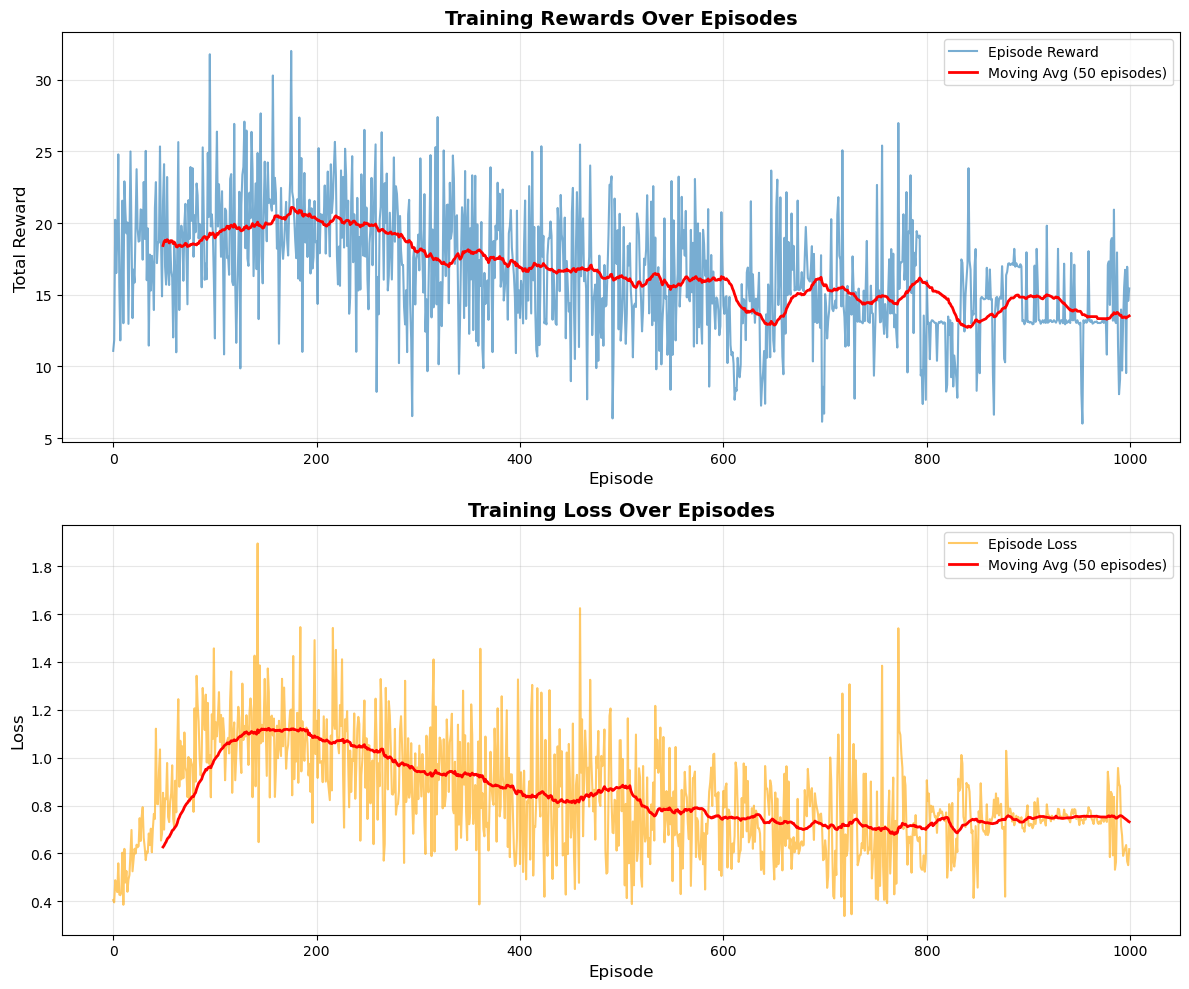

Convergence analysis plot saved to convergence_analysis.png


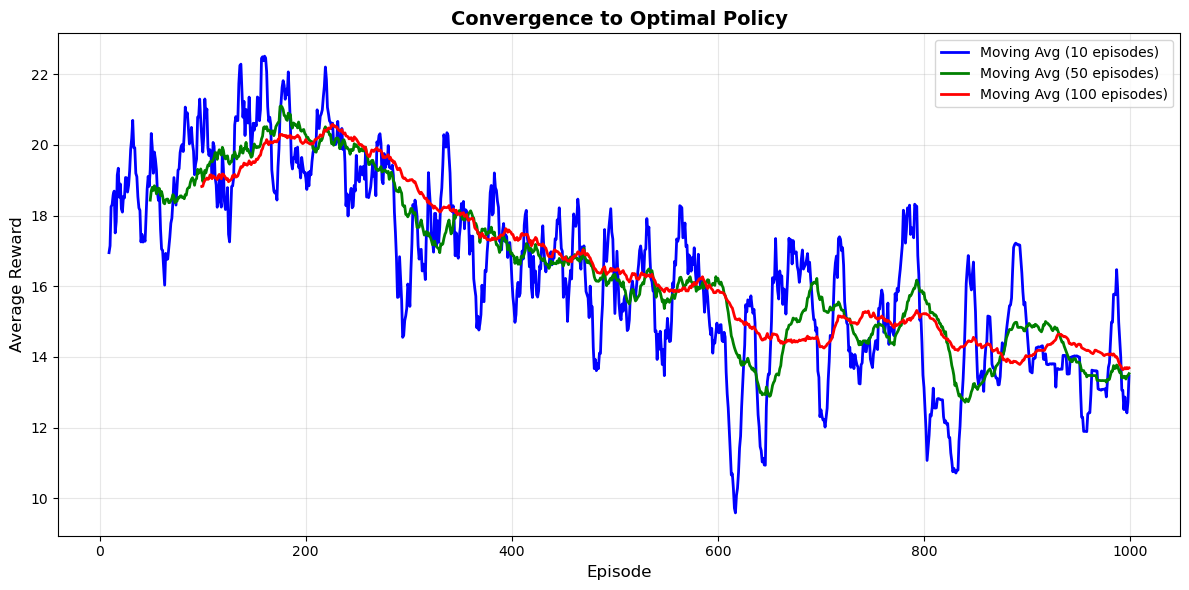


Step 6: Evaluating trained agent...
Q-table loaded from q_table_traffic_light_ep1000.pkl
EVALUATING AGENT
Evaluation Episode 1: Reward = -55.33, Emergencies Cleared: 9, Switches: 1
Average Reward: -55.33
Std Reward: 0.00
Average Phase Switches: 1.00
Average Emergencies Cleared: 9.00

Saving visualization data...
Visualization data saved to visualization_data.pkl

Step 7: Saving results...

PROJECT COMPLETED SUCCESSFULLY!

Files generated:
  - q_table_traffic_light_ep*.pkl: Trained Q-table checkpoints
  - training_results.png: Training rewards and losses
  - convergence_analysis.png: Convergence plot
  - training_results.pkl: All training data
  - visualization_data.pkl: Data for creating video


In [14]:
if __name__ == "__main__":
    main()

In [15]:
import shutil

Saved: demo_emergency.gif


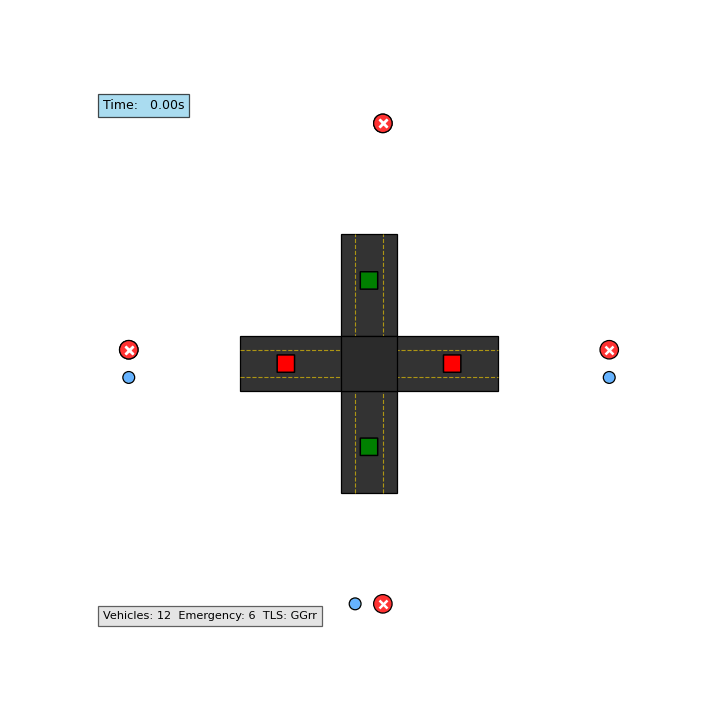

In [16]:
# SECTION 11 — VISUALISATION
import os, random, pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, FancyBboxPatch
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display, HTML


LANE_OFFSETS = [-7.5, 7.5]
ROAD_LENGTH = 140
ROAD_BOUND = 150
JUNCTION_HALF = 15
STOP_LINE = JUNCTION_HALF + 8

DESIRED_SPEED = 2.6
MAX_ACCEL = 0.35
MIN_GAP = 8.0
TIME_STEP = 1.0

PHASE_NS_GREEN = 80
PHASE_NS_YELLOW = 16
PHASE_ALL_RED = 6
PHASE_EW_GREEN = 80
PHASE_EW_YELLOW = 16

PREEMPT_CHECK_DIST = 40
PREEMPT_ALLRED = 6
PREEMPT_GREEN = 60

SPAWN_PROB = 0.07
EMERGENCY_PROB = 0.015
MAX_VEHICLES = 240


def s_to_xy(s, direction, lane):
    """Convert longitudinal coordinate s to (x,y) on lane centerline (consistent with main code)."""
    offs = LANE_OFFSETS[int(lane) % len(LANE_OFFSETS)]
    if direction == 'N' or direction == 'S':
        return (offs, s)
    else:
        return (s, offs)

def initial_s_for_spawn(direction):
    """Return starting s for spawning vehicles."""
    return ROAD_BOUND + random.uniform(0.0, 30.0) if direction in ['N','E'] else -ROAD_BOUND - random.uniform(0.0, 30.0)

def s_passed_boundary(s):
    return abs(s) > ROAD_BOUND + 60

def infer_dir_from_xy(x, y):
    if abs(x) >= abs(y):
        return 'E' if x > 0 else 'W'
    else:
        return 'N' if y > 0 else 'S'

def _snap_to_lane_center(pos_or_s, direction, lane=0):
    lane_offset = LANE_OFFSETS[int(lane) % len(LANE_OFFSETS)]
    half_len = ROAD_LENGTH / 2.0

    if isinstance(pos_or_s, (int, float, np.floating, np.integer)):
        s = float(pos_or_s)
    elif isinstance(pos_or_s, tuple) and len(pos_or_s) == 2:
        x_in, y_in = pos_or_s
        if direction in ['N', 'S']:
            s = float(y_in)
        else:
            s = float(x_in)
    else:
        s = 0.0

    s = np.clip(s, -half_len - 60.0, half_len + 60.0)

    if direction in ['N','S']:
        x = lane_offset
        y = s
    else:
        x = s
        y = lane_offset

    return float(x), float(y)

def tls_for_phase(phase_name):
    if phase_name == 'NS_GREEN':
        return {'N':'G','S':'G','E':'r','W':'r'}
    if phase_name == 'NS_YELLOW':
        return {'N':'y','S':'y','E':'r','W':'r'}
    if phase_name == 'EW_GREEN':
        return {'N':'r','S':'r','E':'G','W':'G'}
    if phase_name == 'EW_YELLOW':
        return {'N':'r','S':'r','E':'y','W':'y'}
    return {'N':'r','S':'r','E':'r','W':'r'}


def synthesize_structured_frames(num_frames=500,
                                 seed=3,
                                 emergency_prob=None,
                                 force_one_emergency_per_dir=True,
                                 preempt_check_dist=None,
                                 preempt_green=None):
    # runtime default resolution
    if emergency_prob is None: emergency_prob = globals().get('EMERGENCY_PROB', 0.015)
    if preempt_check_dist is None: preempt_check_dist = globals().get('PREEMPT_CHECK_DIST', 40)
    if preempt_green is None: preempt_green = globals().get('PREEMPT_GREEN', 60)

    random.seed(seed); np.random.seed(seed)
    frames = []
    vehicles = {}
    idc = 0

    def spawn(direction, force_emergency=False):
        nonlocal idc
        idc += 1
        vid = f'v{idc}'
        lane = random.choice([0,1])
        typ = 'emergency' if (force_emergency or random.random() < emergency_prob) else 'regular'
        s = initial_s_for_spawn(direction)
        v = DESIRED_SPEED * (1.5 if typ=='emergency' else 1.0)
        return {'id':vid, 'dir':direction, 'lane':lane, 's':s, 'v':v, 'type':typ}

    # seed traffic
    for d in ['N','S','E','W']:
        for i in range(3):
            force_em = force_one_emergency_per_dir and i == 0
            veh = spawn(d, force_em); vehicles[veh['id']] = veh

    phase_sequence = [
        ('NS_GREEN', PHASE_NS_GREEN),
        ('NS_YELLOW', PHASE_NS_YELLOW),
        ('ALL_RED_1', PHASE_ALL_RED),
        ('EW_GREEN', PHASE_EW_GREEN),
        ('EW_YELLOW', PHASE_EW_YELLOW),
        ('ALL_RED_2', PHASE_ALL_RED)
    ]
    phase_idx = 0; phase_timer = phase_sequence[phase_idx][1]

    preempt_active = False; preempt_dir = None; preempt_timer = 0; preempt_allred_timer = 0
    opposite = {'N':'S','S':'N','E':'W','W':'E'}

    for t in range(num_frames):
        # spawn
        if len(vehicles) < MAX_VEHICLES and random.random() < SPAWN_PROB:
            d = random.choice(['N','S','E','W'])
            v = spawn(d); vehicles[v['id']] = v

        # maintain minimal activity
        if t % 30 == 0:
            counts = {d: sum(1 for vv in vehicles.values() if vv['dir']==d) for d in ['N','S','E','W']}
            for d,c in counts.items():
                if c < 2:
                    v = spawn(d); vehicles[v['id']] = v

        # emergency check
        emergency_request = None
        for v in vehicles.values():
            if v['type'] == 'emergency':
                if abs(v['s']) < (preempt_check_dist + 15):
                    emergency_request = v['dir']; break

        if not preempt_active and emergency_request is not None:
            preempt_active = True; preempt_dir = emergency_request
            preempt_allred_timer = PREEMPT_ALLRED; preempt_timer = preempt_green

        # determine tls
        if preempt_active:
            if preempt_allred_timer > 0:
                tls = {'N':'r','S':'r','E':'r','W':'r'}; preempt_allred_timer -= 1
            else:
                tls = {'N':'r','S':'r','E':'r','W':'r'}
                tls[preempt_dir] = 'G'; tls[opposite[preempt_dir]] = 'G'
                preempt_timer -= 1
                if preempt_timer <= 0:
                    preempt_active = False; preempt_dir = None
                    phase_idx = 0; phase_timer = phase_sequence[phase_idx][1]
        else:
            pname,_ = phase_sequence[phase_idx]
            if pname.startswith('NS_GREEN'): tls = tls_for_phase('NS_GREEN')
            elif pname.startswith('NS_YELLOW'): tls = tls_for_phase('NS_YELLOW')
            elif pname.startswith('EW_GREEN'): tls = tls_for_phase('EW_GREEN')
            elif pname.startswith('EW_YELLOW'): tls = tls_for_phase('EW_YELLOW')
            else: tls = tls_for_phase('ALL_RED')
            phase_timer -= 1
            if phase_timer <= 0:
                phase_idx = (phase_idx + 1) % len(phase_sequence)
                phase_timer = phase_sequence[phase_idx][1]

        # group & update motion
        dir_groups = {'N':[], 'S':[], 'E':[], 'W':[]}
        for v in vehicles.values(): dir_groups[v['dir']].append(v)
        for d in dir_groups:
            dir_groups[d].sort(key=lambda vv: abs(vv['s']))

        for d, group in dir_groups.items():
            for idx, veh in enumerate(group):
                desired = DESIRED_SPEED * (1.5 if veh['type']=='emergency' else 1.0)
                v_cur = veh['v']
                accel = np.clip(desired - v_cur, -MAX_ACCEL, MAX_ACCEL)
                v_new = v_cur + accel
                v_new = float(np.clip(v_new, 0.0, DESIRED_SPEED * 2.0))

                light = tls.get(d, 'r')
                if d in ['N','E']:
                    stop_target = JUNCTION_HALF
                    dist_to_stop = veh['s'] - stop_target
                else:
                    stop_target = -JUNCTION_HALF
                    dist_to_stop = stop_target - veh['s']

                front_gap = None
                if idx > 0:
                    ahead = group[idx-1]
                    front_gap = (ahead['s'] - veh['s']) if d in ['N','E'] else (veh['s'] - ahead['s'])

                stopping = False
                if light != 'G' and dist_to_stop < (MIN_GAP*1.5 + 5):
                    stopping = True
                if front_gap is not None and front_gap < MIN_GAP:
                    v_new = min(v_new, 0.12)
                if stopping:
                    v_new = min(v_new, 0.08)

                if d in ['N','E']:
                    veh['s'] = veh['s'] - v_new * TIME_STEP
                    veh['v'] = v_new
                else:
                    veh['s'] = veh['s'] + v_new * TIME_STEP
                    veh['v'] = v_new

                if s_passed_boundary(veh['s']):
                    veh['_remove'] = True

        # remove off-screen
        to_del = [vid for vid, v in vehicles.items() if v.get('_remove', False)]
        for vid in to_del: vehicles.pop(vid, None)

        # pack frame
        veh_list = []
        for v in vehicles.values():
            x,y = s_to_xy(v['s'], v['dir'], v['lane'])
            veh_list.append({'id':v['id'], 'type':v['type'], 'dir':v['dir'], 'pos':(x,y), 's':v['s'], 'speed':v['v'], 'lane':v['lane']})

        tls_str = ''.join([tls[d] for d in ['N','S','E','W']])
        frames.append({'time': t*0.1, 'vehicles': veh_list, 'tls': tls_str})

    return frames

# Visualization (uses s_to_xy helper above)

def create_visualization_video_fixed(data_file='visualization_data_structured.pkl',
                                     output_file='traffic_structured_fixed.gif',
                                     max_frames=800,
                                     show_inline=True,
                                     emergency_flash=True):
    # load frames (or synthesize)
    if data_file and os.path.exists(data_file):
        try:
            with open(data_file, 'rb') as f:
                viz_data = pickle.load(f)
        except Exception:
            viz_data = synthesize_structured_frames(num_frames=max_frames)
            with open(data_file, 'wb') as f: pickle.dump(viz_data, f)
    else:
        viz_data = synthesize_structured_frames(num_frames=max_frames)
        if data_file:
            with open(data_file, 'wb') as f: pickle.dump(viz_data, f)

    total_frames = min(len(viz_data), max_frames)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_facecolor('white'); ax.set_aspect('equal'); ax.set_xlim(-150,150); ax.set_ylim(-150,150); ax.axis('off')

    ROAD_W = 30
    road_vertical = Rectangle((-ROAD_W/2, -ROAD_LENGTH/2), ROAD_W, ROAD_LENGTH, facecolor='#333', edgecolor='k', zorder=1)
    road_horizontal = Rectangle((-ROAD_LENGTH/2, -ROAD_W/2), ROAD_LENGTH, ROAD_W, facecolor='#333', edgecolor='k', zorder=1)
    ax.add_patch(road_vertical); ax.add_patch(road_horizontal)
    ax.add_patch(Rectangle((-ROAD_W/2, -ROAD_W/2), ROAD_W, ROAD_W, facecolor='#2b2b2b', edgecolor='k', zorder=3))

    for off in LANE_OFFSETS:
        ax.plot([-ROAD_LENGTH/2, ROAD_LENGTH/2], [off, off], linestyle='--', linewidth=0.9, color='gold', alpha=0.6, zorder=2)
        ax.plot([off, off], [-ROAD_LENGTH/2, ROAD_LENGTH/2], linestyle='--', linewidth=0.9, color='gold', alpha=0.6, zorder=2)

    TLS_DIST = ROAD_W/2 + 10; TLS_SIZE = 9
    tls_positions = {
        'N': (0, ROAD_LENGTH/2 - TLS_DIST),
        'S': (0, -ROAD_LENGTH/2 + TLS_DIST),
        'E': (ROAD_LENGTH/2 - TLS_DIST, 0),
        'W': (-ROAD_LENGTH/2 + TLS_DIST, 0)
    }
    tls_art = {}
    for d, (x, y) in tls_positions.items():
        box = FancyBboxPatch((x - TLS_SIZE/2, y - TLS_SIZE/2), TLS_SIZE, TLS_SIZE,
                             boxstyle='round,pad=0.2', linewidth=1.2, facecolor='red',
                             edgecolor='black', zorder=12)
        ax.add_patch(box); tls_art[d] = box

    time_text = ax.text(0.02, 0.96, '', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='skyblue', alpha=0.7))
    stats_text = ax.text(0.02, 0.04, '', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='lightgrey', alpha=0.6))

    vehicle_artists = {}
    emergency_overlays = {}

    def tls_color(ch):
        if ch in ['G','g','1']: return 'green'
        if ch in ['y','Y']: return 'orange'
        return 'red'

    def animate(i):
        frame = viz_data[i]
        tls_state = frame.get('tls','rrrr'); tls_state = tls_state.ljust(4,'r')
        for idx, d in enumerate(['N','S','E','W']):
            tls_art[d].set_facecolor(tls_color(tls_state[idx]))

        present = set(); vcount = 0; ecount = 0
        flash_scale = 1.0 + 0.25 * np.sin(2 * np.pi * (i / 6.0)) if emergency_flash else 1.0

        for v in frame.get('vehicles', []):
            vid = v.get('id')
            typ = v.get('type','regular')
            lane = v.get('lane', v.get('lane_choice', 0))
            # Prefer structured 's' when present
            if 's' in v:
                s_val = v['s']
                x_frame, y_frame = s_to_xy(s_val, v['dir'], lane)
            else:
                pos = v.get('pos', (0.0,0.0))
                x_frame, y_frame = _snap_to_lane_center(pos, v.get('dir', infer_dir_from_xy(pos[0], pos[1])), lane)

            # strict snapping to lane centerline
            x_frame, y_frame = _snap_to_lane_center((x_frame, y_frame), v.get('dir', infer_dir_from_xy(x_frame, y_frame)), lane)

            vcount += 1
            if typ == 'emergency': ecount += 1
            present.add(vid)

            if vid in vehicle_artists:
                art = vehicle_artists[vid]
                if typ == 'emergency':
                    art.center = (x_frame, y_frame)
                    art.set_radius(5.0 * flash_scale)
                    ov = emergency_overlays.get(vid)
                    if ov is not None:
                        ov.set_data([x_frame], [y_frame])
                else:
                    art.center = (x_frame, y_frame)
            else:
                is_em = (typ == 'emergency')
                if is_em:
                    color = '#ff3333'
                    radius = 5.0
                    circ = Circle((x_frame, y_frame), radius=radius, facecolor=color, edgecolor='k', zorder=25)
                    ax.add_patch(circ); vehicle_artists[vid] = circ
                    ov_line, = ax.plot([x_frame],[y_frame], marker='x', markersize=6, markeredgewidth=2, linestyle='None', zorder=30, markeredgecolor='white')
                    emergency_overlays[vid] = ov_line
                else:
                    color = '#66b3ff'
                    radius = 3.2
                    circ = Circle((x_frame, y_frame), radius=radius, facecolor=color, edgecolor='k', zorder=20)
                    ax.add_patch(circ); vehicle_artists[vid] = circ

        for vid in list(vehicle_artists.keys()):
            if vid not in present:
                vehicle_artists[vid].remove(); vehicle_artists.pop(vid, None)
                if vid in emergency_overlays:
                    emergency_overlays[vid].remove(); emergency_overlays.pop(vid, None)

        time_text.set_text(f"Time: {frame.get('time',0):6.2f}s")
        stats_text.set_text(f"Vehicles: {vcount}  Emergency: {ecount}  TLS: {tls_state}")

        artists = list(tls_art.values()) + list(vehicle_artists.values()) + list(emergency_overlays.values()) + [time_text, stats_text]
        return artists

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=60, blit=True, repeat=True)

    try:
        writer = PillowWriter(fps=15)
        anim.save(output_file, writer=writer, dpi=90)
        print("Saved:", output_file)
    except Exception as e:
        print("Couldn't save GIF (displaying inline instead):", e)

    plt.close(fig)
    if os.path.exists(output_file) and show_inline:
        display(Image(filename=output_file))
    else:
        display(HTML(anim.to_jshtml()))

frames = synthesize_structured_frames(num_frames=300, seed=0, emergency_prob=0.08, force_one_emergency_per_dir=True)
with open('visualization_data_structured_demo.pkl', 'wb') as f: pickle.dump(frames, f)
create_visualization_video_fixed(data_file='visualization_data_structured_demo.pkl',
                                 output_file='demo_emergency.gif',
                                 max_frames=300,
                                 show_inline=True,
                                 emergency_flash=True)